# <따릉이 대여량 예측하기>

## 1. 데이터 확인

### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### 데이터 불러오기

In [23]:
bike = pd.read_csv('../비어플/train.csv', encoding='cp949')
test = pd.read_csv('../비어플/test.csv', encoding='cp949')

In [24]:
bike.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,24/10/2018,1492,16,NaN,42,1.3,1976,5.0,1.22,0.0,0.0,NaN,No Holiday,Yes
1,01/05/2018,1536,14,23.0,64,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes
2,14/11/2018,327,2,6.2,59,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes
3,31/08/2018,170,4,23.2,83,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes
4,26/06/2018,45,5,23.7,64,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes


In [25]:
test.head()

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,11/07/2018,22,27.1,79,1.2,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes
1,28/11/2018,11,5.7,15,1.1,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes
2,18/04/2018,15,19.0,21,3.3,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes
3,09/03/2018,14,8.0,42,NaN,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes
4,28/10/2018,16,12.2,65,1.9,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes


In [26]:
print(bike.shape, test.shape)

(7008, 14) (1752, 13)


## 2. 데이터 1차 전처리
전처리 근거는 4주차 과제_전처리.ipynb 참고

### 2.1 칼럼명 수정

In [27]:
bike.columns = ['Date','Rented Bike Count','Hour','Temperature','Humidity','Wind speed','Visibility',
               'Dew point temperature','Solar Radiation','Rainfall','Snowfall','Seasons','Holiday','Functioning Day']
test.columns = ['Date','Hour','Temperature','Humidity','Wind speed','Visibility',
               'Dew point temperature','Solar Radiation','Rainfall','Snowfall','Seasons','Holiday','Functioning Day']

### 2.2 파생변수 생성

In [28]:
bike['datetime'] = pd.to_datetime(bike['Date'], format='%d/%m/%Y')
bike['year'] = bike['datetime'].dt.year
bike['month'] = bike['datetime'].dt.month
bike['day'] = bike['datetime'].dt.day

test['datetime'] = pd.to_datetime(test['Date'], format='%d/%m/%Y')
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day

In [29]:
bike['week'] = bike['datetime'].dt.day_name()
test['week'] = test['datetime'].dt.day_name()

In [30]:
bike['Rainfall_Binary'] = bike['Rainfall'].apply(lambda x: 1 if x > 0.0 else 0)
test['Rainfall_Binary'] = test['Rainfall'].apply(lambda x: 1 if x > 0.0 else 0)

bike['Snowfall_Binary'] = bike['Snowfall'].apply(lambda x: 1 if x > 0.0 else 0)
test['Snowfall_Binary'] = test['Snowfall'].apply(lambda x: 1 if x > 0.0 else 0)

### 2.3 결측치 처리

#### Seasons

In [31]:
# 'Seasons' 열의 결측치를 각 월에 해당하는 계절로 대체하는 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    elif month in [12, 1, 2]:
        return 'Winter'

# 'Seasons' 열의 결측치를 월별로 채우기
bike['Seasons'] = bike['Seasons'].fillna(bike['month'].apply(get_season))
test['Seasons'] = test['Seasons'].fillna(test['month'].apply(get_season))

#### Humidity = 0

In [32]:
bike['Humidity'] = bike['Humidity'].interpolate(method='spline', order=3)
test['Humidity'] = test['Humidity'].interpolate(method='spline', order=3)

#### Temperature

In [33]:
import math
def calculate_temperature(dew_point_temp, humidity):
    temperature = dew_point_temp + (100 - humidity)/5
    return temperature
    
na_temp = bike['Temperature'].isnull()
for i in range(len(bike)):
    if na_temp[i]:
        dew_point_temp = bike.loc[i, 'Dew point temperature']
        humidity = bike.loc[i, 'Humidity']
        calculated_temp = calculate_temperature(dew_point_temp, humidity)
        if (calculated_temp >= -30.0):  # -30도보다 낮으면 비정상으로 간주
            bike.loc[i, 'Temperature'] = calculated_temp
        else:
            bike['Temperature'] = bike['Temperature'].interpolate(method='spline', order=3)

na_temp = test['Temperature'].isnull()
for i in range(len(test)):
    if na_temp[i]:
        dew_point_temp = test.loc[i, 'Dew point temperature']
        humidity = test.loc[i, 'Humidity']
        calculated_temp = calculate_temperature(dew_point_temp, humidity)
        if (calculated_temp >= -30.0):  # -30도보다 낮으면 비정상으로 간주
            test.loc[i, 'Temperature'] = calculated_temp
        else:
            test['Temperature'] = test['Temperature'].interpolate(method='spline', order=3)

#### Wind speed

In [34]:
bike['Wind speed'] = bike['Wind speed'].interpolate(method='spline', order=3)
test['Wind speed'] = test['Wind speed'].interpolate(method='spline', order=3)

## 3. 데이터 2차 전처리

### 3.1 명목형 변수 원핫인코딩
명목형 변수 : Seasons, Holiday, Functioning Day, week, month, day, Hour, Rainfall_Binary, Snowfall_Binary

In [35]:
ohe = OneHotEncoder(sparse_output=False)
result_ohe_bike = ohe.fit_transform(bike[['Seasons', 'Holiday', 'Functioning Day', 'week',
                                          'month', 'day', 'Hour', 'Rainfall_Binary', 'Snowfall_Binary']])
df_ohe_bike = pd.DataFrame(result_ohe_bike, columns=ohe.get_feature_names_out(['Seasons', 'Holiday', 'Functioning Day',
                                                                                'week', 'month', 
                                                                               'day', 'Hour', 'Rainfall_Binary', 
                                                                               'Snowfall_Binary']))

ohe = OneHotEncoder(sparse_output=False)
result_ohe_test = ohe.fit_transform(test[['Seasons', 'Holiday', 'Functioning Day', 'week',
                                          'month', 'day', 'Hour', 'Rainfall_Binary', 'Snowfall_Binary']])
df_ohe_test = pd.DataFrame(result_ohe_test, columns=ohe.get_feature_names_out(['Seasons', 'Holiday', 'Functioning Day',
                                                                                'week', 'month', 
                                                                               'day', 'Hour', 'Rainfall_Binary', 
                                                                               'Snowfall_Binary']))

bike_v1 = pd.concat([bike, df_ohe_bike], axis=1)
test_v1 = pd.concat([test, df_ohe_test], axis=1)

### 3.2 최종 변수

In [36]:
bike = bike_v1.drop(['Date', 'datetime', 'Seasons', 'Holiday', 'Functioning Day', 'Seasons_Spring', 'week', 'week_Thursday',
                     'year', 'month', 'day', 'Hour', 'Rainfall_Binary','Snowfall_Binary', 'month_7', 'day_31',
                    'Hour_23'], axis=1)
test = test_v1.drop(['Date', 'datetime', 'Seasons', 'Holiday', 'Functioning Day', 'Seasons_Spring', 'week', 'week_Thursday',
                     'year', 'month', 'day', 'Hour', 'Rainfall_Binary','Snowfall_Binary', 'month_7', 'day_31',
                    'Hour_23'], axis=1)

In [37]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 90 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      7008 non-null   int64  
 1   Temperature            7008 non-null   float64
 2   Humidity               7008 non-null   int64  
 3   Wind speed             7008 non-null   float64
 4   Visibility             7008 non-null   int64  
 5   Dew point temperature  7008 non-null   float64
 6   Solar Radiation        7008 non-null   float64
 7   Rainfall               7008 non-null   float64
 8   Snowfall               7008 non-null   float64
 9   Seasons_Autumn         7008 non-null   float64
 10  Seasons_Summer         7008 non-null   float64
 11  Seasons_Winter         7008 non-null   float64
 12  Holiday_Holiday        7008 non-null   float64
 13  Holiday_No Holiday     7008 non-null   float64
 14  Functioning Day_No     7008 non-null   float64
 15  Func

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperature            1752 non-null   float64
 1   Humidity               1752 non-null   int64  
 2   Wind speed             1752 non-null   float64
 3   Visibility             1752 non-null   int64  
 4   Dew point temperature  1752 non-null   float64
 5   Solar Radiation        1752 non-null   float64
 6   Rainfall               1752 non-null   float64
 7   Snowfall               1752 non-null   float64
 8   Seasons_Autumn         1752 non-null   float64
 9   Seasons_Summer         1752 non-null   float64
 10  Seasons_Winter         1752 non-null   float64
 11  Holiday_Holiday        1752 non-null   float64
 12  Holiday_No Holiday     1752 non-null   float64
 13  Functioning Day_No     1752 non-null   float64
 14  Functioning Day_Yes    1752 non-null   float64
 15  week

### 3.3 Train/Valid 셋 분리

In [39]:
X = bike.drop("Rented Bike Count", axis=1).copy()
y = bike["Rented Bike Count"].copy()

<Axes: >

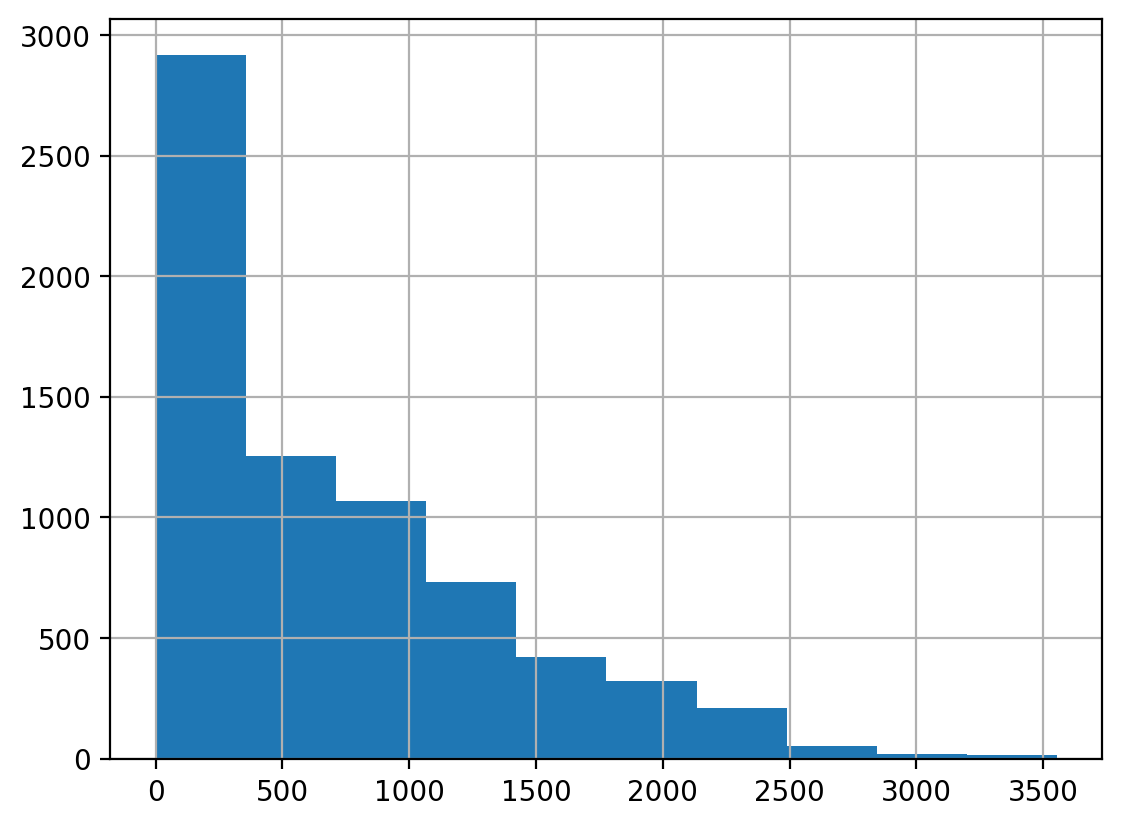

In [40]:
y.hist()

- 왼쪽으로 왜곡되어 있음 -> 정규성을 띌 수 있게 로그 변환을 해준다.

In [41]:
y_log = np.log1p(y)

<Axes: >

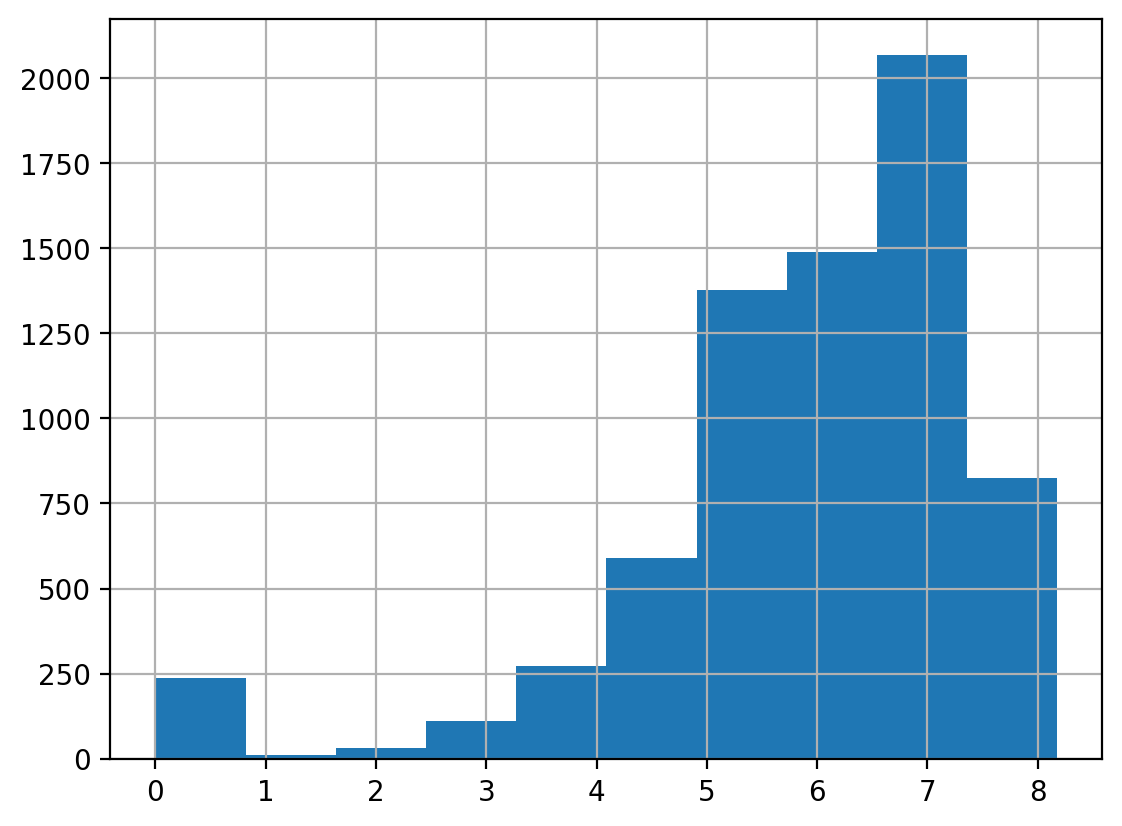

In [42]:
y_log.hist()

- 우측으로 치우쳐져 있긴 하지만, 원래 데이터보다는 정규성을 띄고 있음.

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y_log, train_size=0.8, test_size=0.2, random_state=100)

In [44]:
X_test = test.copy()

### 3.4 변수 스케일링

In [45]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

## 4. 모델 학습

### 4.1 LinearRegression

- 데이터의 선형 관계를 기반으로 예측을 수행하는 모델로써, 독립 변수와 종속 변수 사이의 선형 관계를 설명.
- 주어진 데이터와 예측 데이터의 오차 평균을 최소화할 수 있는 최적의 기울기와 절편을 찾는 것을 목적으로 함.
- "정규 방정식", "경사하강법"
- 모델의 성능은 주로 MSE를 통해 평가됨.

#### (1) 모델 선언

In [46]:
lr_reg = LinearRegression()

#### (2) 하이퍼 파라미터 확인

In [47]:
print(lr_reg.get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


#### (3) 모델 학습/평가

In [48]:
lr_reg.fit(X_train, y_train)
pred_lr = lr_reg.predict(X_val)

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_model_predict(model, X_train, X_val, y_train, y_val, pred):
    print(model.score(X_train, y_train))
    print(model.score(X_val, y_val))

    # Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
    y_val = np.expm1(y_val)
    pred = np.expm1(pred)

    r2 = r2_score(y_val, pred)
    mae = mean_absolute_error(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print("R2: %f" % (r2))
    print("MSE: %f" % (mse))
    print("RMSE: %f" % (rmse))
    print("MAE: %f" % (mae))
    print('#####################################')
    print(f'              오차확인               ')
    result_df = pd.DataFrame(y_val.values, columns=['real_count'])
    result_df['pred_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['pred_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:10])

get_model_predict(lr_reg, X_train, X_val, y_train, y_val, pred_lr)

0.8891146246532542
0.8926698234599169
R2: 0.779242
MSE: 95890.473614
RMSE: 309.661870
MAE: 198.767021
#####################################
              오차확인               
      real_count  pred_count    diff
1078      1141.0      2719.0  1578.0
5         1934.0      3492.0  1558.0
747        959.0      2204.0  1245.0
348       2272.0      1060.0  1212.0
774       2108.0       916.0  1192.0
1261       475.0      1628.0  1153.0
73        2019.0       904.0  1115.0
754       1798.0       708.0  1090.0
801       2214.0      1129.0  1085.0
688       1899.0       820.0  1079.0


MSE 값이 매우 큰 것을 확인. 선형회귀 모델에서는 MSE값으로 성능 확인을 하므로 해당 모델은 좋지 않은 것으로 판단.

### 4.2 RandomForestRegression
- 일반화 및 성능이 우수
- 파라미터 조정이 쉬움
- 과적합이 잘 되지 않음
- 훈련 시 메모리 소모가 큼
- 개별 트리 분석이 어렵고 트리 분리가 복잡해지는 경향 존재

In [50]:
# 아래의 모델들은 변수 스케일링이 필요하지 않은 모델이므로 스케일링하지 않고 진행한다.
X_train, X_val, y_train, y_val = train_test_split(X, y_log, train_size=0.8, test_size=0.2, random_state=100)

#### (1) 모델 선언

In [51]:
rf_reg = RandomForestRegressor()

#### (2) 하이퍼 파라미터 확인

In [52]:
print(rf_reg.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


#### (3) 모델 학습/평가

In [53]:
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_val)

In [54]:
get_model_predict(rf_reg, X_train, X_val, y_train, y_val, pred)

0.9916715738516381
0.950953003056495
R2: 0.923149
MSE: 33381.818368
RMSE: 182.706919
MAE: 108.901728
#####################################
              오차확인               
      real_count  pred_count    diff
747        959.0      2149.0  1190.0
1020      1557.0      2641.0  1084.0
482        578.0      1496.0   918.0
637       1933.0      1025.0   908.0
729       1289.0       445.0   844.0
902       1548.0       723.0   825.0
340       1491.0      2310.0   819.0
765       2378.0      1564.0   814.0
751       1956.0      1169.0   787.0
158       2254.0      1500.0   754.0


#### (4) 하이퍼 파라미터 튜닝
- n_estimator : 생성할 트리의 개수
- max_features : 노드를 분할할 때 고려할 특성의 무작위 하위 집합의 크기
- max_depth : 트리의 최대 깊이
- min_samples_split : 노드를 분할하기 위해 필요한 최소한의 샘플 개수
- min_samples_leaf : 노드를 분할하기 위해 leaf 노드가 가져야할 최소한의 샘플
- max_leaf_nodes : 생성될 수 있는 최대 리프 노드의 개수를 제한
- random_state : 랜덤 시드 지정

In [55]:
params_grid_rf = {
    'n_estimators' : [200, 300, 500],
    'max_features' : ['sqrt','log2'],
    'max_depth' : [3, 5, 7],
    'min_samples_split' : [2, 5, 10]
}

In [57]:
gs_rf = GridSearchCV(estimator=rf_reg,param_grid=params_grid_rf , cv = 3)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 500]})

In [58]:
gs_rf.best_score_

0.8047231483038436

In [59]:
gs_rf.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 300}

In [60]:
rf_reg_tune = gs_rf.best_estimator_
rf_reg_tune.fit(X_train, y_train)
pred_rf_tune = rf_reg_tune.predict(X_val)
get_model_predict(rf_reg_tune, X_train, X_val, y_train, y_val, pred_rf_tune)

0.8177543044854099
0.8160415594325702
R2: 0.423774
MSE: 250294.917508
RMSE: 500.294831
MAE: 312.341351
#####################################
              오차확인               
      real_count  pred_count    diff
406       3256.0       982.0  2274.0
892       3277.0      1014.0  2263.0
523       3123.0       960.0  2163.0
1237      3380.0      1289.0  2091.0
848       3309.0      1301.0  2008.0
1363      2716.0       766.0  1950.0
457       2916.0       986.0  1930.0
117       2965.0      1096.0  1869.0
739       2826.0       965.0  1861.0
21        2661.0       822.0  1839.0


### 4.3 XGBoostRegression
- 높은 예측 성능을 보이며 과적합 방지를 위한 다양한 하이퍼파라미터 제공
- 빠른 속도로 대용량 데이터 세트 처리 가능
- 다양한 하이퍼파라미터를 조절할 수 있지만 최적의 조합을 찾기 어려움
- 많은 메모리 소모

#### (1) 모델 선언

In [61]:
xgb_reg = XGBRegressor()

#### (2) 하이퍼 파라미터 확인

In [62]:
print(xgb_reg.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


#### (3) 모델 학습/평가

In [63]:
xgb_reg.fit(X_train, y_train)
pred_xgb = xgb_reg.predict(X_val)

In [64]:
get_model_predict(xgb_reg, X_train, X_val, y_train, y_val, pred_xgb)

0.9926811086385855
0.9583063404043253
R2: 0.931540
MSE: 29737.087248
RMSE: 172.444447
MAE: 102.568556
#####################################
              오차확인               
      real_count  pred_count    diff
747        959.0      2199.0  1240.0
989       2519.0      1465.0  1054.0
1390       215.0      1251.0  1036.0
380        282.0      1187.0   905.0
359       1664.0      2569.0   905.0
215       1373.0      2251.0   878.0
690       2268.0      3094.0   826.0
1020      1557.0      2379.0   822.0
482        578.0      1315.0   737.0
0         2479.0      1754.0   725.0


#### (4) 하이퍼 파라미터 튜닝
- n_estimators : 부스팅 단계의 수 결정
- learning_rate : 각 부스팅 단계에서의 학습률 결정
- max_depth : 각 트리의 최대 깊이
- min_child_weight : 자식 노드에서의 최소 가중치
- subsample : 각 트리를 학습할 때 사용할 데이터의 비율
- colsample_bytree : 각 트리에서 사용할 피처의 비율

In [42]:
params_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [43]:
gs_xgb = GridSearchCV(estimator=xgb_reg,param_grid=params_grid_xgb , cv = 3)
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]})

In [44]:
gs_xgb.best_score_

0.9486637040816497

In [45]:
gs_xgb.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 300,
 'subsample': 0.8}

In [65]:
xgb_reg_tune = XGBRegressor(colsample_bytree=1.0, learning_rate=0.1, max_depth=5,
                           min_child_weight=1, n_estimators=300, subsample=0.8)
xgb_reg_tune.fit(X_train, y_train)
pred_xgb_tune = xgb_reg_tune.predict(X_val)

In [66]:
get_model_predict(xgb_reg_tune, X_train, X_val, y_train, y_val, pred_xgb_tune)

0.9885509253217998
0.9586263080762434
R2: 0.930614
MSE: 30139.087663
RMSE: 173.606128
MAE: 102.180338
#####################################
              오차확인               
      real_count  pred_count    diff
747        959.0      2335.0  1376.0
690       2268.0      3395.0  1127.0
482        578.0      1602.0  1024.0
380        282.0      1220.0   938.0
359       1664.0      2560.0   896.0
117       2965.0      2075.0   890.0
1020      1557.0      2419.0   862.0
0         2479.0      1661.0   818.0
1134       137.0       929.0   792.0
729       1289.0       527.0   762.0


### 4.4 LGBMRegressor

#### (1) 모델 선언

In [67]:
lgbm_reg = LGBMRegressor()

#### (2) 하이퍼 파라미터 확인

In [68]:
print(lgbm_reg.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


#### (3) 모델 학습/평가

In [69]:
lgbm_reg.fit(X_train, y_train)
pred_lgbm = lgbm_reg.predict(X_val)

In [70]:
get_model_predict(lgbm_reg, X_train, X_val, y_train, y_val, pred_lgbm)

0.975629186001978
0.9530459681771059
R2: 0.928735
MSE: 30955.175710
RMSE: 175.940830
MAE: 105.153903
#####################################
              오차확인               
      real_count  pred_count    diff
747        959.0      2346.0  1387.0
380        282.0      1232.0   950.0
340       1491.0      2423.0   932.0
1020      1557.0      2452.0   895.0
0         2479.0      1657.0   822.0
729       1289.0       474.0   815.0
821       1995.0      1224.0   771.0
1134       137.0       895.0   758.0
690       2268.0      3023.0   755.0
835       1330.0       614.0   716.0


#### (4) 하이퍼 파라미터 튜닝

In [52]:
params_grid_lgbm = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [53]:
gs_lgbm = GridSearchCV(estimator=lgbm_reg, param_grid=params_grid_lgbm , cv = 3)
gs_lgbm.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 3, 5, 7],
                         'min_child_samples': [20, 30, 50],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [31, 63, 127],
                         'subsample': [0.6, 0.8, 1.0]})

In [54]:
gs_lgbm.best_score_

0.9480429961009474

In [55]:
gs_lgbm.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'n_estimators': 500,
 'num_leaves': 31,
 'subsample': 0.6}

In [71]:
lgbm_reg_tune = LGBMRegressor(colsample_bytree=0.8,learning_rate=0.1,
                             max_depth=-1, min_child_samples=20,
                             n_estimators=500, num_leaves=31,
                             subsample=0.6)
lgbm_reg_tune.fit(X_train, y_train)
pred_lgbm_tune = lgbm_reg_tune.predict(X_val)

In [72]:
get_model_predict(lgbm_reg_tune, X_train, X_val, y_train, y_val, pred_lgbm_tune)

0.9946641435502277
0.9623412574323095
R2: 0.941975
MSE: 25204.457584
RMSE: 158.759118
MAE: 90.653048
#####################################
              오차확인               
      real_count  pred_count    diff
1020      1557.0      2790.0  1233.0
690       2268.0      3469.0  1201.0
747        959.0      2149.0  1190.0
1328      2162.0      3188.0  1026.0
380        282.0      1238.0   956.0
359       1664.0      2545.0   881.0
637       1933.0      1175.0   758.0
340       1491.0      2244.0   753.0
482        578.0      1266.0   688.0
653       1117.0       440.0   677.0


#### (5) 변수 중요도 확인

<function matplotlib.pyplot.show(close=None, block=None)>

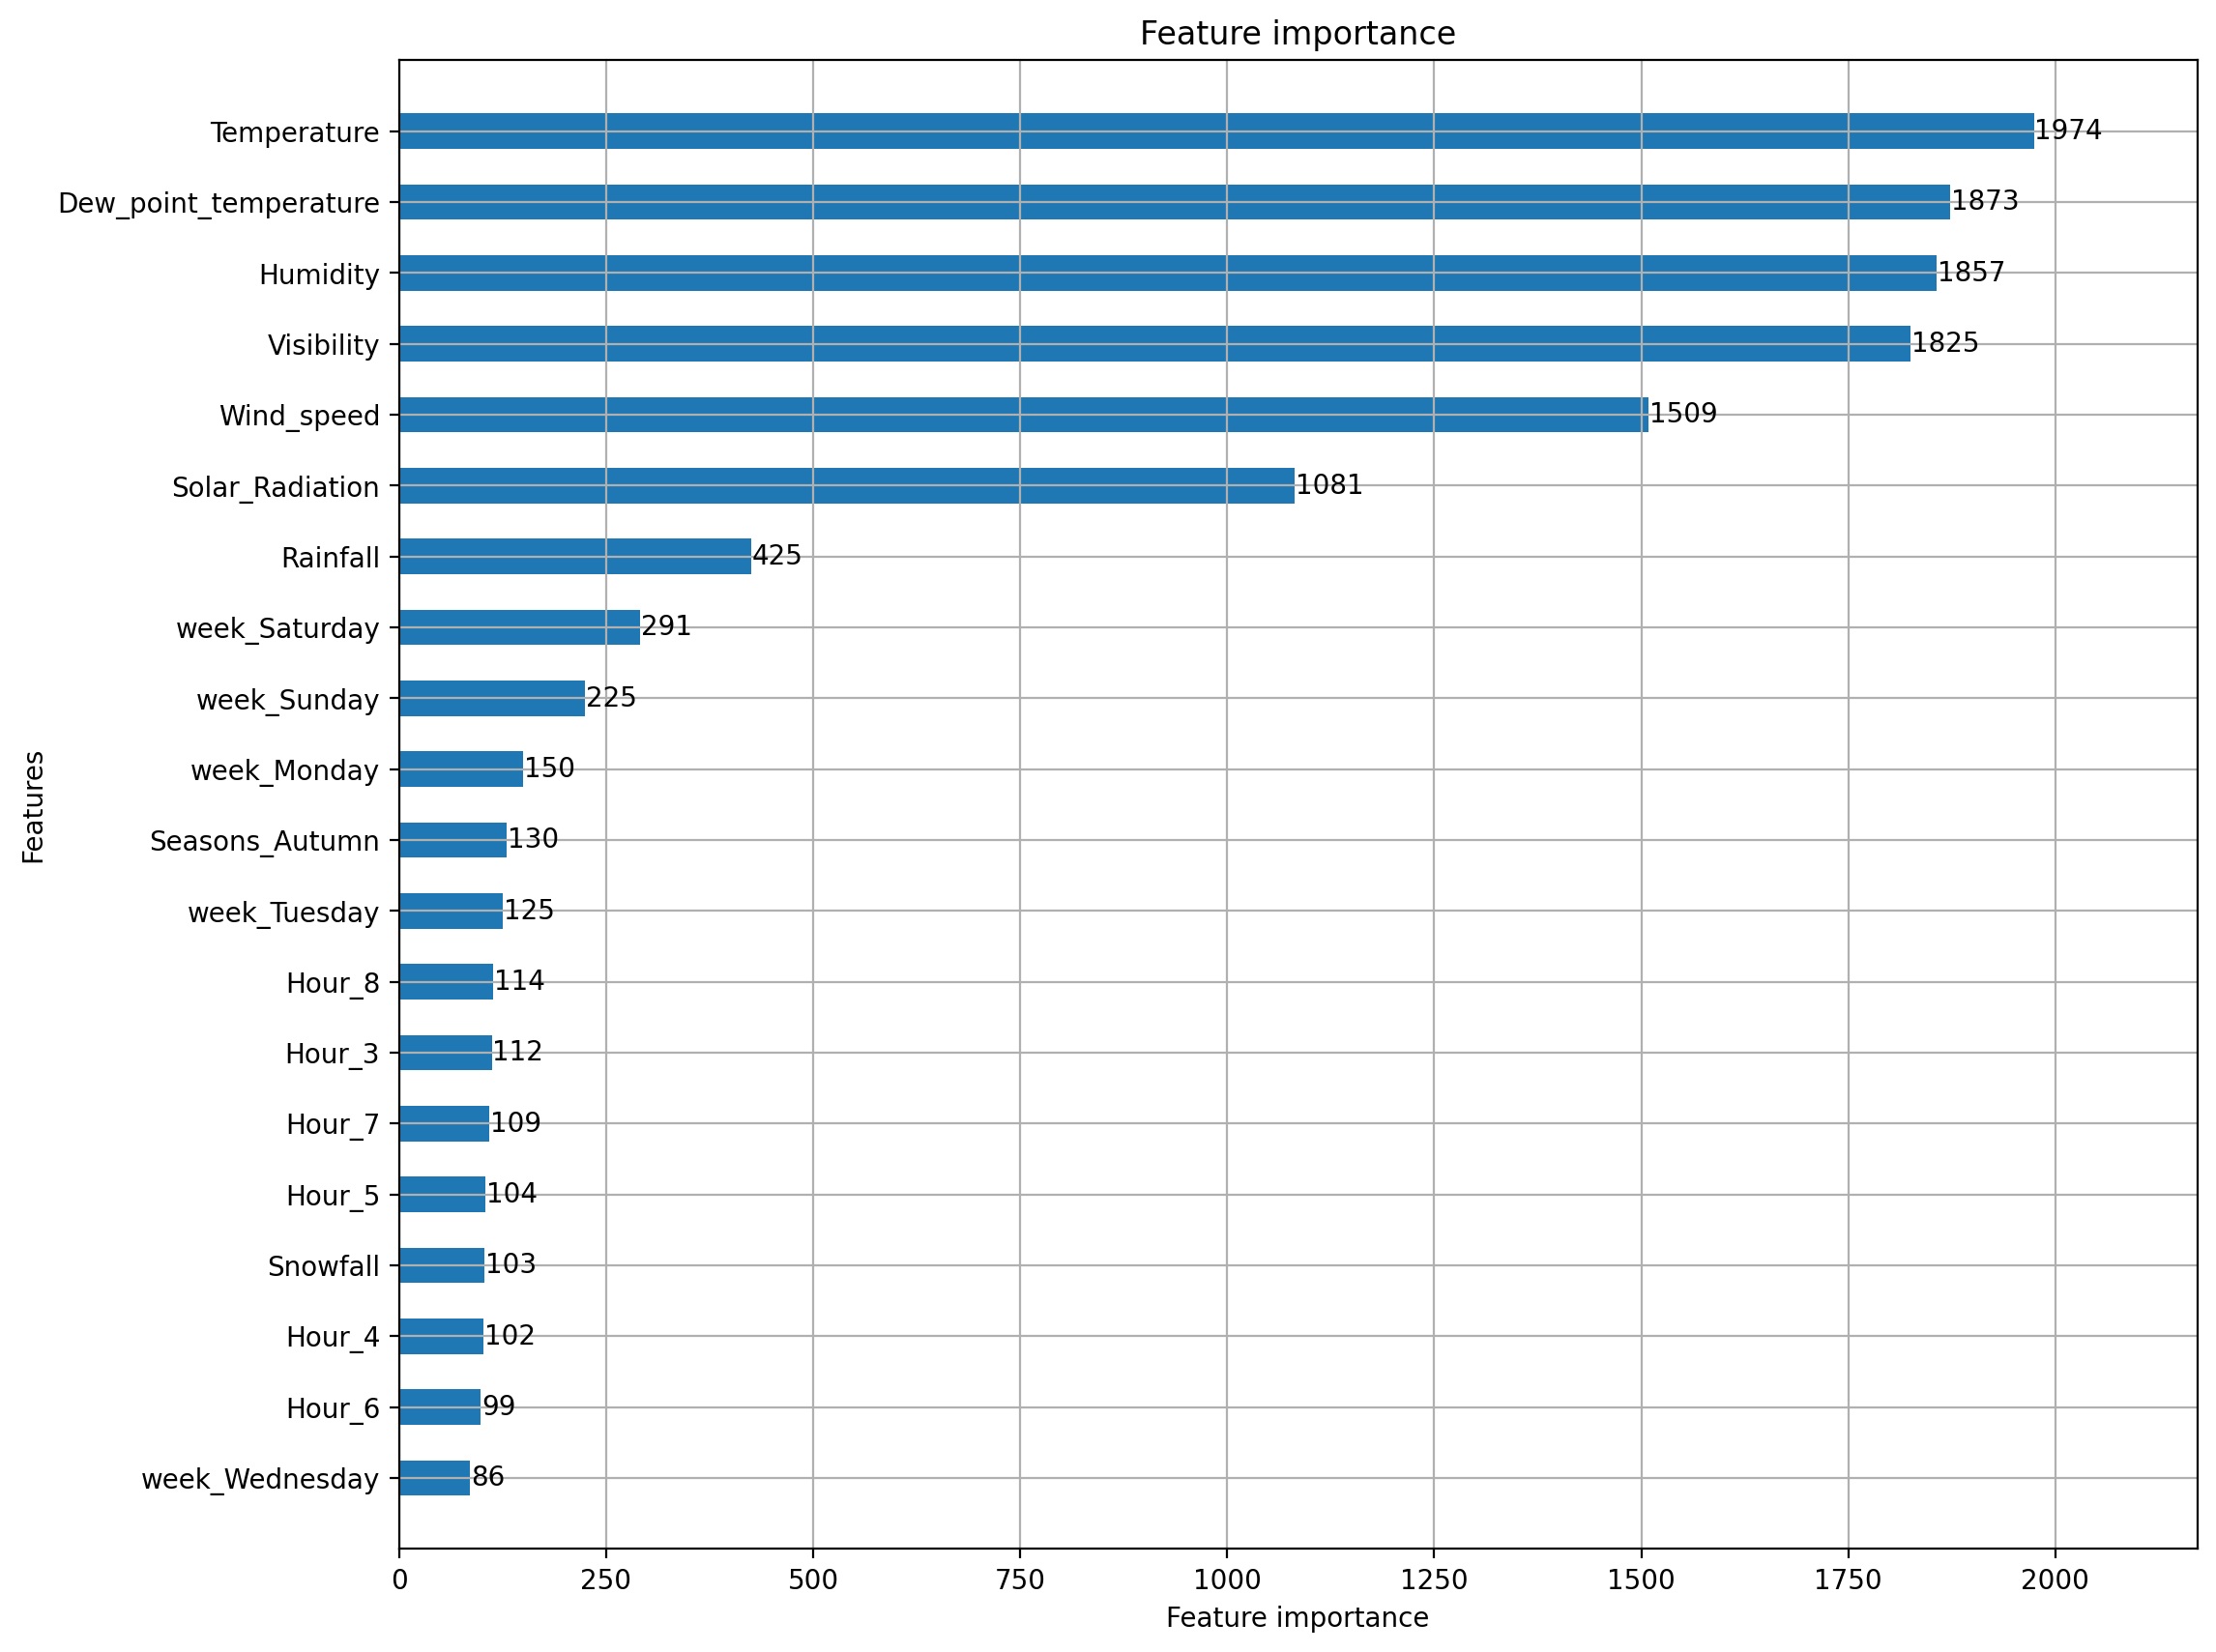

In [73]:
from lightgbm import plot_importance
plot_importance(lgbm_reg_tune, figsize=(12,10), height=0.5, max_num_features=20) # 상위 20개 추출
plt.show

- 'Temperature', 'Visibility', 'Dew_point_temperature', 'Humidity', 'Wind_speed' 순으로 변수 중요도가 높게 나옴.
- 온도에 따라 대여량의 영향을 미쳤다는 것을 보면 사람들은 더운지, 추운지, 선선한지 등의 환경 요인에 따라 대여를 결정한다고 볼 수 있음.
- 가시성, 이슬점, 습도의 영향을 많이 받는 것을 보면 비가 내린 후, 습도가 올라가고 앞이 잘 보이지 않으면 이용률이 낮아지고 미세먼지가 심해지면 가시성이 떨어져 대여량이 줄어들 수 있음을 알 수 있음.
- 또한, 요일, 시간 등의 요인에 따라 대여량의 변화가 보인다는 것을 알 수 있음.
- 이러한 점을 바탕으로 대여량이 적은 시간 혹은 날짜, 계절을 이용하여 자전거의 유지 보수를 진행할 수 있고, 대여량이 많은 위치 등의 데이터와 결합하여 어떤 곳에 자전거를 더 두어야 할 지 예측할 수 있을 것이다.

### 4.5 모델 선정

선정된 모델 : LGBMRegressor

선정 이유 : 파라미터 튜닝을 한 모델까지 고려하여 총 8개의 모델을 비교했을 때, LGBMRegressor의 하이퍼 파라미터를 튜닝한 모델이 가장 좋은 score를 보여줬다. r2_score는 약 0.9532, MSE는 약 19357.8374, RMSE는 약 139.1325, MAE는 약 82.4943이 나왔다. 해당 모델로 예측했을 경우, 실제값과의 오차가 가장 작았던 것을 볼 수 있었고 변수들의 특징을 잘 적용한 모델이라고 판단했다. 이러한 이유를 바탕으로 최종 모델로 선정하여 test 데이터를 예측한다.

## 최종 모델 - test 예측

In [74]:
pred = lgbm_reg_tune.predict(X_test)
pred = np.expm1(pred)
pred = pd.DataFrame(pred.astype('int64'), columns=['Rented Bike Count'])

In [75]:
test = pd.concat([test, pred], axis=1)
test

,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons_Autumn,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes,week_Friday,week_Monday,week_Saturday,week_Sunday,week_Tuesday,week_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Rainfall_Binary_0,Rainfall_Binary_1,Snowfall_Binary_0,Snowfall_Binary_1,Rented Bike Count
0,27.1,79,1.200000,1578,23.1,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,263
1,5.7,15,1.100000,1419,-19.0,0.98,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,316
2,19.0,21,3.300000,1716,-3.8,2.88,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,311
3,8.0,42,1.563110,1690,-4.1,1.24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,363
4,12.2,65,1.900000,2000,5.8,0.52,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,15.3,60,2.000000,2000,7.5,0.35,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,283
1748,8.5,59,2.700000,1927,0.9,0.16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,224
1749,21.3,53,1.800000,2000,11.3,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [76]:
test.to_csv('test_따릉이_예측완료.csv', index = False)

### (+) kfold 교차검증

In [77]:
X_train = bike.drop(['Rented Bike Count'], axis =1)
y_train = bike['Rented Bike Count']
y_train = np.log1p(y_train)

In [78]:
lgbm_reg_tune = LGBMRegressor(colsample_bytree=0.8,learning_rate=0.1,
                             max_depth=-1, min_child_samples=20,
                             n_estimators=500, num_leaves=31,
                             subsample=0.6)

In [79]:
r2 = []
mae = []
rmse = []
mse = []

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

for trn_idx, val_idx in kfold.split(X_train, y_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    lgbm_reg_tune.fit(X_trn, y_trn)
    y_pred = lgbm_reg_tune.predict(X_val)
    
    print('예측 완료')

    y_val = np.expm1(y_val)
    y_pred = np.expm1(y_pred)

    r2.append(r2_score(y_val, y_pred))
    mae.append(mean_absolute_error(y_val, y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    mse.append(mean_squared_error(y_val, y_pred))

mean_r2 = sum(r2) / len(r2)
mean_mae = sum(mae) / len(mae)
mean_rmse = sum(rmse) / len(rmse)
mean_mse = sum(mse) / len(mse)

print("R2:", mean_r2)
print('MAE:', mean_mae)
print('RMSE:', mean_rmse)
print('MSE:', mean_mse)

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료
R2: 0.9390653743070196
MAE: 92.046887665996
RMSE: 159.6646380008978
MSE: 25514.23755406526


In [80]:
result = []

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

for trn_idx, val_idx in kfold.split(X_train, y_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    lgbm_reg_tune.fit(X_trn, y_trn)
    
    y_pred = lgbm_reg_tune.predict(X_test)
    y_pred = np.expm1(y_pred)
    
    result.append(y_pred)

In [81]:
# axis=0으로 최빈값 계산

final_predictions = np.mean(result, axis=0).astype('int64')

In [82]:
final_predictions

array([283, 361, 277, ...,   0, 418, 248], dtype=int64)

In [83]:
test['Rented Bike Count'] = final_predictions

<Axes: >

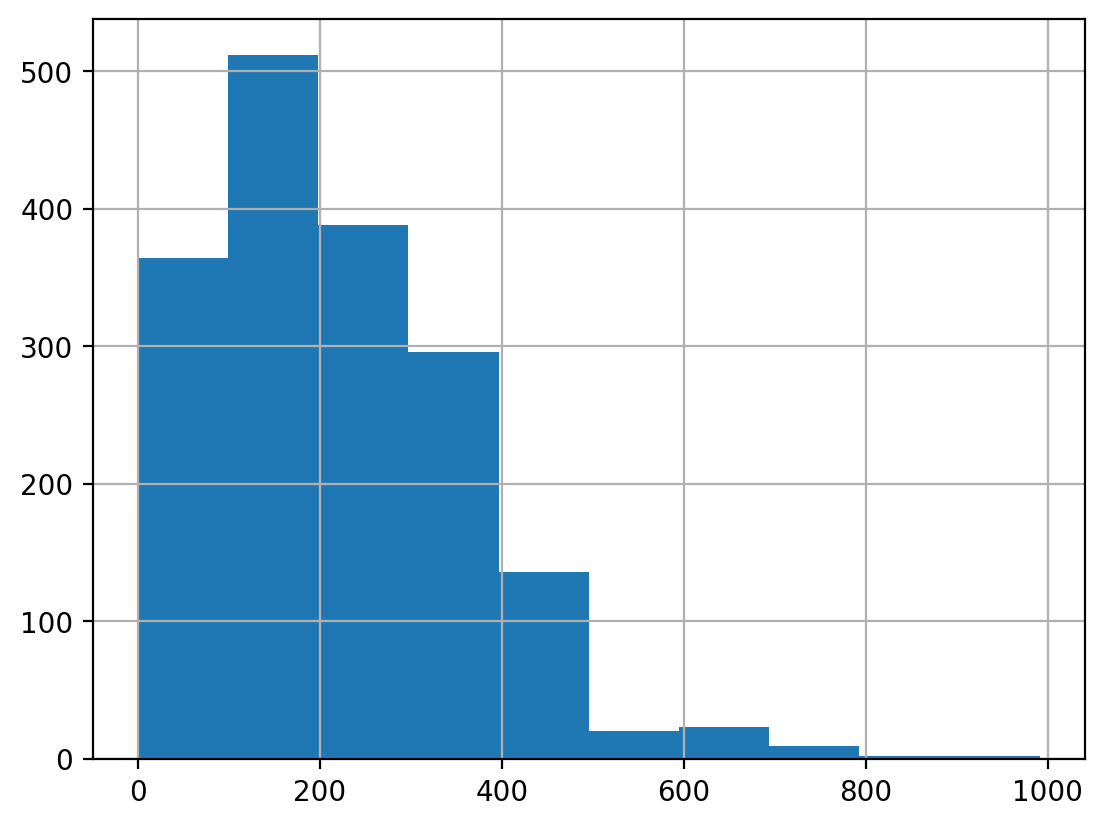

In [84]:
test['Rented Bike Count'].hist()

In [85]:
test.to_csv('test_따릉이_예측완료_kf.csv', index = False)